<html>
    <head>
        <title>Sample data Preview</title>
        <!-- colors {
        green: #60b24b,
        blue_light: #52a29b,
        blue: #3d74c9,
        purple: #6244d5,
        red: #b44e4e,
        yellowish: #9b9948
}
//-->
    </head>
    <body>
        <div class="navigation">
            <ul id='1' style="margin-bottom:5%;text-align:center;">
                <li style="display:inline;margin-right:5%;padding:2%;background-color:#dddddd;color:#60b24b">Exploring Sample Data </li>
                <li style="display:inline;margin-right:5%;padding:2%;background-color:#dddddd;color:#3d74c9">Visualizing the data </li>
                <li style="display:inline;margin-right:5%;padding:2%;background-color:#dddddd;color:#b44e4e">Performing a dataset cleanup</li>
            </ul>
            <ul id='2' style="text-align:center;">
                <li style="display:inline;margin-right:5%;padding:2%;background-color:#dddddd;color:#60b24b"> Building the mode</li>
                <li style="display:inline;margin-right:5%;padding:2%;background-color:#dddddd;color:#3d74c9"> Internal Validation</li>
                <li style="display:inline;margin-right:5%;padding:2%;background-color:#dddddd;color:#52a29b"> External Validation</li>
                <li style="display:inline;margin-right:5%;padding:2%;background-color:#dddddd;color:#6244d5"> Interpretation</li>
                <li style="display:inline;margin-right:5%;padding:2%;background-color:#dddddd;color:#9b9948">Prediction</li>
            </ul>
        </div>
    </body>
</html>

# **Libraries and Frameworks**

In [1]:
# Installing libraries
import sys
if 'google.colab' in sys.modules:
    !pip install scikit-plot
    !pip install shap
    !pip install CHAID
else:
    print('Please install scikit-plot, shape and CHAID libraries using the following commands:\n')
    print('pip install scikit-plot')
    print('pip install shap')
    print('pip install CHAID')

In [0]:
import numpy as np
import pandas as pd
import shap

import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Other
from statsmodels.api import qqplot #for qq plot
from statsmodels.stats.diagnostic import het_breuschpagan,linear_rainbow  #variance equality and linearity tests
from scipy.stats import shapiro #for checking normality
from statsmodels.stats.outliers_influence import variance_inflation_factor #for checking Multicolinearity
from sklearn.metrics import r2_score #R-squared


# Optional, same as LogisticRegression or LinearRegression
import statsmodels.api as sm #statsmodels library
from statsmodels.discrete.discrete_model import Logit

#libraries for modelling and evaluation
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from CHAID import Tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import roc_auc_score,roc_curve # ... 
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, recall_score
import scikitplot as skplt #in case of error run "pip install scikit-plot" in cmd(terminal) and run the code again

In [3]:
# Checking Runtime Environment and importing data
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    dataset_path = "/content/drive/My Drive/sample_data.csv"
else:
    dataset_path = "./Desktop/BA_Group_Project_Analysis/sample_data.csv"

data = pd.read_csv(dataset_path)

data_numbers = data.select_dtypes(exclude=['object']) # Will be used for working with int/float values
data_objects = data.select_dtypes(include=['object']) # Will be used for working with strings/objects values

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Preview**

In [4]:
# Taking a look at the data
print('Shape: ', data.shape, '\n---------------------------------------------')

print('Head: \n',data.head(), '\n---------------------------------------------')
print('Summary: \n',data.describe(), '\n---------------------------------------------')

Shape:  (27420, 131) 
---------------------------------------------
Head: 
    ARV17_MINUS_ARV16  AXM4970T  AXM4971T  ...  STATE_CD  XFC06  XFC07
0            11108.0       7.0        10  ...        CA    3.0    0.0
1              182.0       7.0        14  ...        TX    0.0    1.0
2             5342.0       7.0        14  ...        NY    0.0    0.0
3               85.0       3.0         5  ...        IN    0.0    1.0
4             2245.0       5.0         9  ...        MO    0.0    0.0

[5 rows x 131 columns] 
---------------------------------------------
Summary: 
        ARV17_MINUS_ARV16      AXM4970T  ...         XFC06         XFC07
count       27420.000000  27420.000000  ...  27420.000000  27420.000000
mean         9400.773924      6.664734  ...      2.024252      0.186142
std          9657.697012      2.711635  ...      3.210141      0.658014
min        -18694.000000      0.000000  ...      0.000000      0.000000
25%          3073.500000      5.000000  ...      0.000000     

In [5]:
print('Columns: ',data.columns, '\n---------------------------------------------')
print('Data types:\n\n',data.dtypes.value_counts(), '\n---------------------------------------------')

Columns:  Index(['ARV17_MINUS_ARV16', 'AXM4970T', 'AXM4971T', 'AXM5030T', 'AXM5032T',
       'AXM5130T', 'AXM5131T', 'AXM5930T', 'AXM5931T', 'AXM5932T',
       ...
       'SMARTV40_CRM01', 'SMARTV40_CRN01', 'SMARTV40_CRT01', 'SMARTV40_CRT06',
       'SMARTV40_DDT01', 'SMARTV40_DDT02', 'SMARTV40_DDT18', 'STATE_CD',
       'XFC06', 'XFC07'],
      dtype='object', length=131) 
---------------------------------------------
Data types:

 float64    111
object      11
int64        9
dtype: int64 
---------------------------------------------


In [6]:
#checking number of duplicates, missing values and columns with a single value
print("Duplicates:",data.duplicated().sum())
print("Missing values:",data.isna().sum().sum())
print("Single valued columns:", data.columns[data.nunique()==1])

Duplicates: 19
Missing values: 152691
Single valued columns: Index([], dtype='object')


In [7]:
# Issues with data
#   Data has outliers
#   Data has missing values
#   Data includes columns with unique values

# Shows columns with missing values
print("Missing Values\n\n", data.isna().sum()[data.isna().sum() > 0], 
      '\n-------------------------') # 152,691

# Shows columns with Unique Values
print("Unique Values\n")
for column in data_objects:
  data_column = data_objects[column]
  print(column + ": ",data_column.value_counts().count())
print('-------------------------')

Missing Values

 DEM08                11
SMARTV40_CMG04    23605
SMARTV40_CMG05    26796
SMARTV40_CRM01    27065
SMARTV40_CRN01    26716
SMARTV40_CRT01    22528
SMARTV40_CRT06    25970
dtype: int64 
-------------------------
Unique Values

DEM03:  4
DEM06:  3
DEM08:  13
ENCRYPTED_PIN:  27316
KEYID:  27315
SEGMENT_CODE:  7
SMARTV40_AAU19:  18
SMARTV40_AAU20:  13
SMARTV40_AAU22:  12
SMARTV40_ALE21:  12
STATE_CD:  30
-------------------------


In [8]:
# Shows columns with outliers
def show_outliers(dataset):
  print("Outliers\n")
  for column in dataset.select_dtypes(exclude=['uint8', 'object']):
      data_column = data[column]
      outliers = data_column[((data_column - data_column.mean()) / data_column.std()).abs() > 3]
      if (len(outliers) < 20) and (len(outliers) != 0):
        print(outliers, '\n------------------------------')

show_outliers(data)

# Columns with negative values
data_mins = data.select_dtypes(exclude='object').min()
columns_with_negatives = data_mins[data_mins < 0].keys()
for column in columns_with_negatives:
  print('Column Name: ', column)
  print('Positives: ', (data[column] < 0).value_counts()[0])
  print('Negatives: ', (data[column] < 0).value_counts()[1])
  print('-------------------------')

Outliers

3391    96.0
Name: AXM4970T, dtype: float64 
------------------------------
1365      0
3391     96
3713      0
5142      0
7320      0
14594     0
17271     0
27211     0
Name: AXM4971T, dtype: int64 
------------------------------
3391    999999996
Name: AXM5030T, dtype: int64 
------------------------------
3391    999999996
Name: AXM5032T, dtype: int64 
------------------------------
3391    999999996.0
Name: AXM5130T, dtype: float64 
------------------------------
3391    999999996.0
Name: AXM5131T, dtype: float64 
------------------------------
3391    999999996.0
Name: AXM5930T, dtype: float64 
------------------------------
3391    999999996.0
Name: AXM5931T, dtype: float64 
------------------------------
3391    999999996.0
Name: AXM5932T, dtype: float64 
------------------------------
3391    999999996.0
Name: AXM5933T, dtype: float64 
------------------------------
3391    96.0
Name: AXM8131T, dtype: float64 
------------------------------
3391     96.0
23914    97

In [0]:
# Conclusion:
#   Missing values in SMARTV40_CR..., SMARTV40_CM... and 11 in DEM08.
#   Outliers with values 999999996, 999999997, 96, 97 will have to be removed.
#   columns SMARTV40_ART18 and AXM4970T have large outliers (in AXM4970T 0 is an outlier).
#   columns ENCRYPTED_PIN and KEYID have too many unique values and have to be removed.
#   Drop XFC06, XFC07 and SEGMENT_CODE. EXP_ID ?

RESPONSE_FLAG    2
dtype: int64


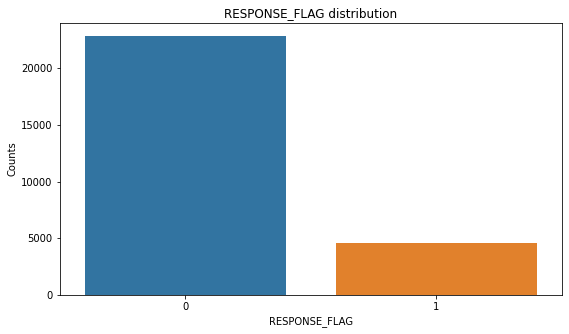

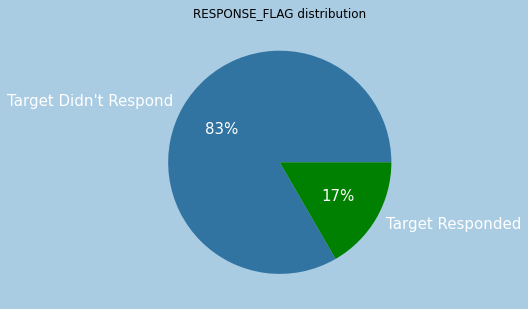


Values with Correlation Above 90%


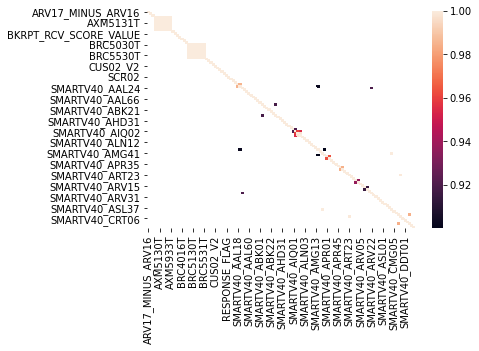


Missing Values Per Flag
0: 
 DEM08                10
SMARTV40_CMG04    19731
SMARTV40_CMG05    22349
SMARTV40_CRM01    22557
SMARTV40_CRN01    22228
SMARTV40_CRT01    18877
SMARTV40_CRT06    21674
dtype: int64
1: 
 DEM08                1
SMARTV40_CMG04    3874
SMARTV40_CMG05    4447
SMARTV40_CRM01    4508
SMARTV40_CRN01    4488
SMARTV40_CRT01    3651
SMARTV40_CRT06    4296
dtype: int64


In [10]:
# Exploring the Target

# Finding the Target variable
print(data.nunique()[data.nunique() == 2])

#let's visualise the distribution of flags
plt.figure(figsize=(9,5))
sns.countplot(data.RESPONSE_FLAG)
plt.title("RESPONSE_FLAG distribution")
plt.ylabel('Counts')
plt.show()

pie_chart = plt.figure(figsize=(5,8))
plt.pie(data.RESPONSE_FLAG.value_counts(normalize=True).mul(100).rename("RESPONSE_FLAG percentages"),
        labels=["Target Didn't Respond", 'Target Responded'], colors=['#3274a1', 'green'], 
         autopct='%1.0f%%', textprops={'color':"w", 'fontsize': 15})
plt.title("RESPONSE_FLAG distribution")
pie_chart.patch.set_facecolor('#A9CCE3')
plt.show()
print('\nValues with Correlation Above 90%')
sns.heatmap(data.corr().abs()[data.corr().abs() >= 0.90])
plt.show()
print()

print('Missing Values Per Flag')
print('0: \n', data[data.isna().sum()[data.isna().sum() > 0].keys()][data['RESPONSE_FLAG'] == 0].isna().sum())
print('1: \n', data[data.isna().sum()[data.isna().sum() > 0].keys()][data['RESPONSE_FLAG'] == 1].isna().sum())

# **Useful Functions**

In [0]:
# Useful Functions 
def model_performance(X0, X1, Y0, Y1, model):
    
    Y0_predict = model.predict(X0)
    Y1_predict = model.predict(X1)
    
    Y0_hat = model.predict_proba(X0)[:,1]
    Y1_hat = model.predict_proba(X1)[:,1]

    print('\nROC AUC Train', roc_auc_score(Y0, Y0_hat).round(3))
    print('ROC AUC Test', roc_auc_score(Y1,Y1_hat).round(3))
    print('-------------------------')
    print('\nClassification Report Train')
    print(classification_report(Y0,Y0_predict))
    print('-------------------------')
    print('\nClassification Report Test')
    print(classification_report(Y1,Y1_predict))
    print('-------------------------')

def logit_model_performance(X0, X1, Y0, Y1, model):
    
    Y0_hat = model.predict(X0)
    Y1_hat = model.predict(X1)
    Y0_class = np.where(Y0_hat>0.5, 1, 0)
    Y1_class = np.where(Y1_hat>0.5, 1, 0)

    print('\nROC AUC Train', roc_auc_score(Y0, Y0_hat).round(3))
    print('ROC AUC Test', roc_auc_score(Y1,Y1_hat).round(3))
    print('-------------------------')
    print('\nClassification Report Train')
    print(classification_report(Y0,Y0_class))
    print('-------------------------')
    print('\nClassification Report Test')
    print(classification_report(Y1,Y1_class))
    print('-------------------------')

# Outputs the columns that need to be dropped
def to_drop(dataset, corr_threshold):
  # Create correlation matrix
  corr_matrix = dataset.corr().abs()

  # Select upper triangle of correlation matrix
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  # Find index of feature columns with correlation greater than corr_threshold
  drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]

  drop = drop + ['EXP_ID','ENCRYPTED_PIN','KEYID', 'XFC06', 'XFC07', 'SEGMENT_CODE',
                 'SEQNUM',
                 'SMARTV40_CMG04', 'SMARTV40_CMG05', 'SMARTV40_CRM01', 
                 'SMARTV40_CRN01', 'SMARTV40_CRT01', 'SMARTV40_CRT06'
                 ]
  return drop

# Drops the outliers from the dataset 
def drop_outliers(dataset):
  for column in dataset.select_dtypes(exclude=['uint8', 'object']):
    data_column = dataset[column]
    outliers = data_column[((data_column - data_column.mean()) / data_column.std()).abs() > 3]
    if (len(outliers) < 20) and (len(outliers) != 0):
      dataset[column] = data_column[((data_column - data_column.mean()) / data_column.std()).abs() < 3]

# Outputs data ready for use
def clean_data (dataset, drop_columns):                         
  new_data = dataset.drop(columns=drop_columns)

  drop_outliers(new_data)

  new_data = pd.get_dummies(new_data,drop_first=True)

  new_data = new_data.dropna() # removes 11 rows. The missing values in DEM03.

  return new_data

# shorter version, to avoid typing test_size and random_state
def tt_split_results(X, Y):
    return train_test_split(X, Y, test_size=0.25, random_state=42)

# Separates target from features
def get_target_and_features(dataset):
    # X and Y
    Y = dataset["RESPONSE_FLAG"]
    X = dataset.drop("RESPONSE_FLAG",axis=1)
    X =  sm.add_constant(X)
    return (X, Y)

# RFE for with n_features for the model
def best_features(model, n_features, X0, Y0):
    estimator = model
    selector =  RFE(estimator, n_features, step=1)
    selector.fit(X0, Y0)
    n_feature_rankings = 1
    best_features = X0.columns[selector.ranking_ <= n_feature_rankings]
    return best_features

# **Cleanup**

In [0]:
#Let's setup the data for processing
also_dropping = ['SMARTV40_AAU19','SMARTV40_AAU20',
                 'SMARTV40_AAU22','SMARTV40_ALE21',
                 'DEM03']

cols_dropped_1 = to_drop(data, 1)

cols_dropped_2 = to_drop(data, 0.99)

cols_dropped_3 = to_drop(data, 0.98)

cols_dropped_4 = to_drop(data, 0.95)

cols_dropped_5 = to_drop(data, 0.9)

cols_dropped_6 = to_drop(data, 0.9) + also_dropping
cols_dropped_7 = to_drop(data, 0.85)

cols_dropped_8 = to_drop(data, 0.85) + also_dropping
cols_dropped_9 = to_drop(data, 0.8)

cols_dropped_10 = to_drop(data, 0.8) + also_dropping

cleanup_methods = [cols_dropped_1, cols_dropped_2, cols_dropped_3, cols_dropped_4,
                   cols_dropped_5, cols_dropped_6, cols_dropped_7, cols_dropped_8,
                   cols_dropped_9, cols_dropped_10]

# **Cleanup Preview**

Data Before


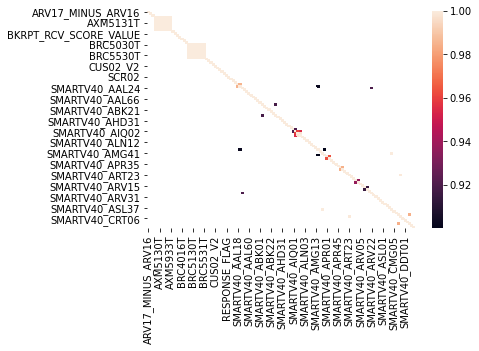

Data After


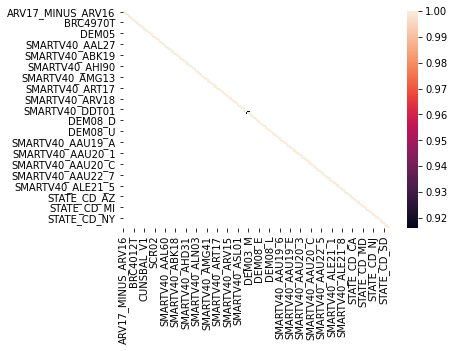

In [13]:
# 90% cleanup
clean_top = clean_data(data,to_drop(data, 0.9))

print('Data Before')
sns.heatmap(data.corr().abs()[data.corr().abs() > 0.9])
plt.show()

print('Data After')
sns.heatmap(clean_top.corr().abs()[clean_top.corr().abs() > 0.9])
plt.show()

# **Logistic regression**

In [14]:
X, Y = get_target_and_features(clean_data(data,cleanup_methods[8]))

# Feature Engineering
# X_final['Diff_2'] = (data_2['ARV17_MINUS_ARV16'].apply(lambda x: 0 if x > 0 else 1)) * data_2['ARV17_MINUS_ARV16'].abs()
# X_final['Diff_1'] = data_2.EXP_ID.apply(lambda x: 0 if x==60 else 1) * data_2.EXP_ID
# min_max_scaler = preprocessing.MinMaxScaler().fit(X0)
# scaler = preprocessing.StandardScaler().fit(X0)

X0, X1, Y0, Y1 = tt_split_results(X, Y)

logit_model_statsmodels = Logit(Y0, X0).fit()

logit_model_performance(X0, X1, Y0, Y1, logit_model_statsmodels)

         Current function value: 0.399508
         Iterations: 35

ROC AUC Train 0.733
ROC AUC Test 0.72
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     17137
           1       0.59      0.10      0.16      3417

    accuracy                           0.84     20554
   macro avg       0.72      0.54      0.54     20554
weighted avg       0.80      0.84      0.79     20554

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      5701
           1       0.56      0.09      0.15      1151

    accuracy                           0.84      6852
   macro avg       0.70      0.54      0.53      6852
weighted avg       0.79      0.84      0.78      6852

-------------------------


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [15]:
X, Y = get_target_and_features(clean_data(data,cleanup_methods[6]))
# Feature Engineering

X0, X1, Y0, Y1 = tt_split_results(X, Y)

logit_model_1 = LogisticRegression(random_state=42).fit(X0,Y0)

model_performance(X0, X1, Y0, Y1, logit_model_1)


ROC AUC Train 0.638
ROC AUC Test 0.631
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     17128
           1       0.39      0.02      0.04      3421

    accuracy                           0.83     20549
   macro avg       0.61      0.51      0.48     20549
weighted avg       0.76      0.83      0.76     20549

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      5704
           1       0.43      0.02      0.04      1146

    accuracy                           0.83      6850
   macro avg       0.63      0.51      0.48      6850
weighted avg       0.77      0.83      0.76      6850

-------------------------


In [0]:
logit_best = best_features(LogisticRegression(random_state=42), 30, X0, Y0)

In [18]:
print('best_features_logit: ', logit_best, '\n')
logit_model_2 = LogisticRegression(random_state=42).fit(X0[logit_best],Y0)
model_performance(X0[logit_best], X1[logit_best], Y0, Y1, logit_model_2)

best_features_logit:  Index(['AXM8131T', 'BKRPT_RCV_SCORE_VALUE', 'BRC4012T', 'BRC4016T', 'BRC8131T',
       'DEM05', 'SCR16', 'SMARTV40_AAL24', 'SMARTV40_AAL25', 'SMARTV40_AAL27',
       'SMARTV40_AAL61', 'SMARTV40_AAL66', 'SMARTV40_ABK01', 'SMARTV40_ABK05',
       'SMARTV40_ABK18', 'SMARTV40_ABK21', 'SMARTV40_ABK23', 'SMARTV40_ALN12',
       'SMARTV40_ALN13', 'SMARTV40_APR30', 'SMARTV40_ART18', 'SMARTV40_ARV01',
       'SMARTV40_ARV05', 'SMARTV40_ARV15', 'SMARTV40_ARV18', 'SMARTV40_ARV23',
       'SMARTV40_ARV31', 'SMARTV40_ASL01', 'SMARTV40_ASL37', 'SMARTV40_DDT01'],
      dtype='object') 


ROC AUC Train 0.673
ROC AUC Test 0.682
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     17128
           1       0.54      0.02      0.04      3421

    accuracy                           0.83     20549
   macro avg       0.69      0.51      0.47     20549
weighted avg       0.79      0.8

In [163]:
param_logit={'fit_intercept':[True, False], 
             'class_weight': ['balanced', None]}

gridsearch = GridSearchCV(estimator=logit_model_2,
                        param_grid=param_logit,
                        cv=5,scoring='roc_auc',verbose=1, n_jobs=-1)

gridsearch.fit(X0[logit_best], Y0)
best_model_params = gridsearch.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.5s finished


In [164]:
best_model_params

{'class_weight': 'balanced', 'fit_intercept': False}

In [54]:
X, Y = get_target_and_features(clean_data(data,cleanup_methods[6]))

# Feature Engineering
# X['SMTALK'] = np.abs(X['SMARTV40_AAL25'] * X['SMARTV40_ABK23'])
# X['SMARTV40_AAL25'] = X['SMARTV40_AAL25'] > 1
# 

logit_model_3 = LogisticRegression(C = 0.001, class_weight = 'balanced',random_state=42,fit_intercept=False).fit(X0[logit_best],Y0)
model_performance(X0[logit_best], X1[logit_best], Y0, Y1, logit_model_3)


ROC AUC Train 0.675
ROC AUC Test 0.684
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.89      0.63      0.74     17128
           1       0.25      0.62      0.36      3421

    accuracy                           0.63     20549
   macro avg       0.57      0.62      0.55     20549
weighted avg       0.79      0.63      0.67     20549

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.89      0.63      0.74      5704
           1       0.26      0.62      0.36      1146

    accuracy                           0.63      6850
   macro avg       0.57      0.63      0.55      6850
weighted avg       0.79      0.63      0.68      6850

-------------------------


In [0]:
cv_scores=cross_val_score(logit_model_3,X[logit_best],Y,cv=5,scoring="roc_auc")

In [56]:
print('cv_scores: ', cv_scores)
print('cv_score: ', np.mean(cv_scores).round(2))

cv_scores:  [0.66828198 0.68183581 0.6667479  0.67970783 0.67118456]
cv_score:  0.67


best_features_logit:  Index(['AXM8131T', 'BKRPT_RCV_SCORE_VALUE', 'BRC4012T', 'BRC4016T', 'BRC8131T',
       'DEM05', 'SCR16', 'SMARTV40_AAL24', 'SMARTV40_AAL25', 'SMARTV40_AAL27',
       'SMARTV40_AAL61', 'SMARTV40_AAL66', 'SMARTV40_ABK01', 'SMARTV40_ABK05',
       'SMARTV40_ABK18', 'SMARTV40_ABK21', 'SMARTV40_ABK23', 'SMARTV40_ALN12',
       'SMARTV40_ALN13', 'SMARTV40_APR30', 'SMARTV40_ART18', 'SMARTV40_ARV01',
       'SMARTV40_ARV05', 'SMARTV40_ARV15', 'SMARTV40_ARV18', 'SMARTV40_ARV23',
       'SMARTV40_ARV31', 'SMARTV40_ASL01', 'SMARTV40_ASL37', 'SMARTV40_DDT01'],
      dtype='object') 



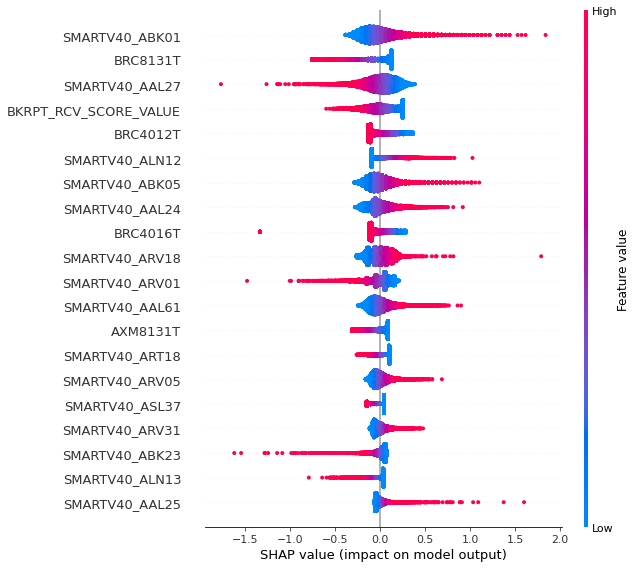

In [57]:
print('best_features_logit: ', logit_best, '\n')
shap_values = shap.LinearExplainer(logit_model_3, X[logit_best]).shap_values(X0[logit_best])
shap.summary_plot(shap_values, X0[logit_best])

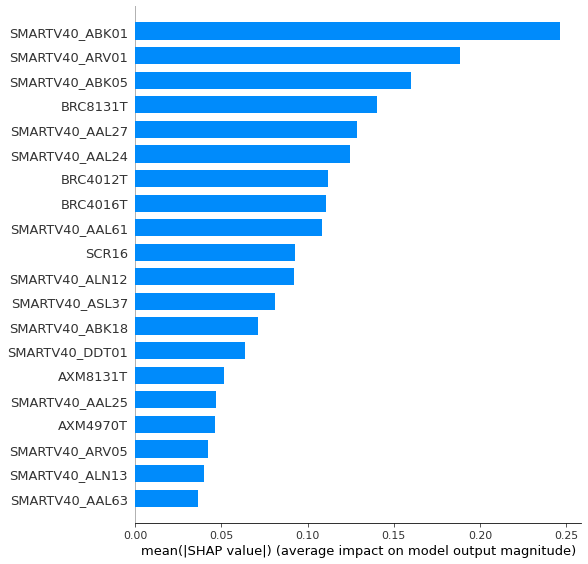

In [173]:
# Explaining the model with SHAP
shap_values = shap.LinearExplainer(logit_model_3, X[logit_best]).shap_values(X0[logit_best])
shap.summary_plot(shap_values, X0[logit_best], plot_type="bar")


# **Decision Tree**

In [450]:
X, Y = get_target_and_features(clean_data(data,cleanup_methods[8]))
# Feature Engineering
X0, X1, Y0, Y1 = tt_split_results(X, Y)

dt_1 = DecisionTreeClassifier(random_state=42)
dt_1.fit(X0,Y0)
model_performance(X0, X1, Y0, Y1, dt_1)


ROC AUC Train 1.0
ROC AUC Test 0.587
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17137
           1       1.00      1.00      1.00      3417

    accuracy                           1.00     20554
   macro avg       1.00      1.00      1.00     20554
weighted avg       1.00      1.00      1.00     20554

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      5701
           1       0.31      0.31      0.31      1151

    accuracy                           0.77      6852
   macro avg       0.59      0.59      0.59      6852
weighted avg       0.77      0.77      0.77      6852

-------------------------


In [0]:
dt_best = best_features(DecisionTreeClassifier(class_weight=None,max_depth=6, min_samples_leaf=60, random_state=42), 30, X0, Y0)

In [378]:
dt_best

Index(['AXM5030T', 'BKRPT_RCV_SCORE_VALUE', 'BRC4003T', 'BRC4012T', 'BRC4016T',
       'BRC4970T', 'BRC4971T', 'BRC5030T', 'BRC8131T', 'CUNSAGE_V1',
       'CUNSBAL_V1', 'CUNSINQ_V1', 'HOMEEQUITY_HEQ09', 'SCR02', 'SCR16',
       'SMARTV40_AAL18', 'SMARTV40_AAL27', 'SMARTV40_ABK05', 'SMARTV40_AHD31',
       'SMARTV40_AIQ01', 'SMARTV40_ALN12', 'SMARTV40_AMG41', 'SMARTV40_ART17',
       'SMARTV40_ARV15', 'SMARTV40_ARV16', 'SMARTV40_DDT01', 'SMARTV40_DDT02',
       'SMARTV40_AAU19_D', 'STATE_CD_AZ', 'STATE_CD_CA'],
      dtype='object')

In [390]:
dt_2 = DecisionTreeClassifier(class_weight=None, max_depth=6, min_samples_leaf=128, random_state=42)
dt_2.fit(X0[dt_best],Y0)
model_performance(X0[dt_best], X1[dt_best], Y0, Y1, dt_2)


ROC AUC Train 0.763
ROC AUC Test 0.748
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     17137
           1       0.67      0.13      0.22      3417

    accuracy                           0.84     20554
   macro avg       0.76      0.56      0.56     20554
weighted avg       0.82      0.84      0.80     20554

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      5701
           1       0.65      0.12      0.20      1151

    accuracy                           0.84      6852
   macro avg       0.75      0.55      0.56      6852
weighted avg       0.81      0.84      0.79      6852

-------------------------


In [391]:
param_dt={'max_depth': range(4,9),
          'min_samples_leaf': range(0,200,15)
          }
gs_dt = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_dt,
                  scoring="roc_auc",cv=5, n_jobs= -1, verbose=1)
gs_dt.fit(X0[dt_best],Y0)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 316 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:   36.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(4, 9),
                         'min_s

In [392]:
gs_dt.best_params_

{'max_depth': 7, 'min_samples_leaf': 90}

In [446]:
dt_3 = DecisionTreeClassifier(class_weight=None,max_depth=6, min_samples_leaf=128,random_state=42).fit(X0[dt_best],Y0)
model_performance(X0[dt_best], X1[dt_best], Y0, Y1, dt_3)


ROC AUC Train 0.763
ROC AUC Test 0.748
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     17137
           1       0.67      0.13      0.22      3417

    accuracy                           0.84     20554
   macro avg       0.76      0.56      0.56     20554
weighted avg       0.82      0.84      0.80     20554

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      5701
           1       0.65      0.12      0.20      1151

    accuracy                           0.84      6852
   macro avg       0.75      0.55      0.56      6852
weighted avg       0.81      0.84      0.79      6852

-------------------------


In [447]:
print("Mean 5-fold ROC AUC score for Tuned DT",np.mean(cross_val_score(estimator=dt_3,X=X[dt_best],y=Y,cv=5, scoring="roc_auc")).round(2))

Mean 5-fold ROC AUC score for Tuned DT 0.75


best_features_logit:  Index(['AXM5030T', 'BKRPT_RCV_SCORE_VALUE', 'BRC4003T', 'BRC4012T', 'BRC4016T',
       'BRC4970T', 'BRC4971T', 'BRC5030T', 'BRC8131T', 'CUNSAGE_V1',
       'CUNSBAL_V1', 'CUNSINQ_V1', 'HOMEEQUITY_HEQ09', 'SCR02', 'SCR16',
       'SMARTV40_AAL18', 'SMARTV40_AAL27', 'SMARTV40_ABK05', 'SMARTV40_AHD31',
       'SMARTV40_AIQ01', 'SMARTV40_ALN12', 'SMARTV40_AMG41', 'SMARTV40_ART17',
       'SMARTV40_ARV15', 'SMARTV40_ARV16', 'SMARTV40_DDT01', 'SMARTV40_DDT02',
       'SMARTV40_AAU19_D', 'STATE_CD_AZ', 'STATE_CD_CA'],
      dtype='object') 



100%|===================| 41051/41108 [07:27<00:00]       

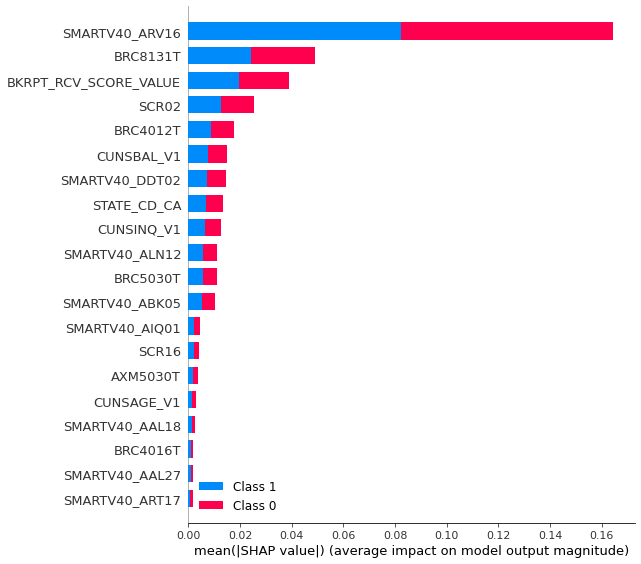

In [448]:
print('best_features_logit: ', dt_best, '\n')
shap_values = shap.TreeExplainer(dt_3, X[dt_best]).shap_values(X0[dt_best])
shap.summary_plot(shap_values, X0[dt_best])

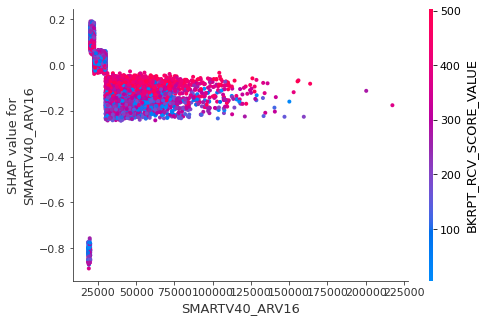

In [449]:
shap.dependence_plot('SMARTV40_ARV16', shap_values[0], X0[dt_best])

# **Random Forest Test**

In [520]:
X, Y = get_target_and_features(clean_data(data,cleanup_methods[8]))
# Feature Engineering
X0, X1, Y0, Y1 = tt_split_results(X, Y)

rf_1 = RandomForestClassifier(class_weight=None,max_depth=14,min_samples_leaf=124, random_state=42).fit(X0,Y0)
model_performance(X0, X1, Y0, Y1, rf_1)


ROC AUC Train 0.787
ROC AUC Test 0.74
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     17137
           1       0.00      0.00      0.00      3417

    accuracy                           0.83     20554
   macro avg       0.42      0.50      0.45     20554
weighted avg       0.70      0.83      0.76     20554

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      5701
           1       0.00      0.00      0.00      1151

    accuracy                           0.83      6852
   macro avg       0.42      0.50      0.45      6852
weighted avg       0.69      0.83      0.76      6852

-------------------------


In [0]:
rf_best = best_features(RandomForestClassifier(class_weight=None,max_depth=14,min_samples_leaf=124, random_state=42), 40, X0, Y0)

In [529]:
rf_best

Index(['ARV17_MINUS_ARV16', 'AXM5030T', 'AXM8131T', 'BKRPT_RCV_SCORE_VALUE',
       'BRC4012T', 'BRC4016T', 'BRC4970T', 'BRC5030T', 'BRC8131T',
       'CUNSAGE_V1', 'CUNSBAL_V1', 'CUNSINQ_V1', 'SCR02', 'SCR16',
       'SMARTV40_AAL01', 'SMARTV40_AAL18', 'SMARTV40_AAL27', 'SMARTV40_AAL61',
       'SMARTV40_AAL66', 'SMARTV40_AAU13', 'SMARTV40_ABK01', 'SMARTV40_ABK05',
       'SMARTV40_ABK18', 'SMARTV40_ABK19', 'SMARTV40_ABK21', 'SMARTV40_ABK22',
       'SMARTV40_ABK23', 'SMARTV40_AIN17', 'SMARTV40_AIQ01', 'SMARTV40_ALN09',
       'SMARTV40_ALN12', 'SMARTV40_ALN13', 'SMARTV40_ART17', 'SMARTV40_ARV15',
       'SMARTV40_ARV16', 'SMARTV40_ARV23', 'SMARTV40_ARV31', 'SMARTV40_ARV34',
       'SMARTV40_DDT01', 'STATE_CD_CA'],
      dtype='object')

In [530]:
['ARV17_MINUS_ARV16', 'AXM5030T', 'AXM8131T', 'BKRPT_RCV_SCORE_VALUE',
       'BRC4012T', 'BRC4016T', 'BRC4970T', 'BRC5030T', 'BRC8131T',
       'CUNSAGE_V1', 'CUNSBAL_V1', 'CUNSINQ_V1', 'SCR02', 'SCR16',
       'SMARTV40_AAL01', 'SMARTV40_AAL18', 'SMARTV40_AAL27', 'SMARTV40_AAL61',
       'SMARTV40_AAL66', 'SMARTV40_AAU13', 'SMARTV40_ABK01', 'SMARTV40_ABK05',
       'SMARTV40_ABK18', 'SMARTV40_ABK19', 'SMARTV40_ABK21', 'SMARTV40_ABK22',
       'SMARTV40_ABK23', 'SMARTV40_AIN17', 'SMARTV40_AIQ01', 'SMARTV40_ALN09',
       'SMARTV40_ALN12', 'SMARTV40_ALN13', 'SMARTV40_ART17', 'SMARTV40_ARV15',
       'SMARTV40_ARV16', 'SMARTV40_ARV23', 'SMARTV40_ARV31', 'SMARTV40_ARV34',
       'SMARTV40_DDT01', 'STATE_CD_CA']

['ARV17_MINUS_ARV16',
 'AXM5030T',
 'AXM8131T',
 'BKRPT_RCV_SCORE_VALUE',
 'BRC4012T',
 'BRC4016T',
 'BRC4970T',
 'BRC5030T',
 'BRC8131T',
 'CUNSAGE_V1',
 'CUNSBAL_V1',
 'CUNSINQ_V1',
 'SCR02',
 'SCR16',
 'SMARTV40_AAL01',
 'SMARTV40_AAL18',
 'SMARTV40_AAL27',
 'SMARTV40_AAL61',
 'SMARTV40_AAL66',
 'SMARTV40_AAU13',
 'SMARTV40_ABK01',
 'SMARTV40_ABK05',
 'SMARTV40_ABK18',
 'SMARTV40_ABK19',
 'SMARTV40_ABK21',
 'SMARTV40_ABK22',
 'SMARTV40_ABK23',
 'SMARTV40_AIN17',
 'SMARTV40_AIQ01',
 'SMARTV40_ALN09',
 'SMARTV40_ALN12',
 'SMARTV40_ALN13',
 'SMARTV40_ART17',
 'SMARTV40_ARV15',
 'SMARTV40_ARV16',
 'SMARTV40_ARV23',
 'SMARTV40_ARV31',
 'SMARTV40_ARV34',
 'SMARTV40_DDT01',
 'STATE_CD_CA']

In [531]:
rf_2 = RandomForestClassifier(class_weight=None,max_depth=14,min_samples_leaf=124, random_state=42).fit(X0[rf_best],Y0)
model_performance(X0[rf_best], X1[rf_best], Y0, Y1, rf_2)


ROC AUC Train 0.792
ROC AUC Test 0.749
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     17137
           1       0.78      0.00      0.01      3417

    accuracy                           0.83     20554
   macro avg       0.81      0.50      0.46     20554
weighted avg       0.82      0.83      0.76     20554

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      5701
           1       0.67      0.00      0.00      1151

    accuracy                           0.83      6852
   macro avg       0.75      0.50      0.46      6852
weighted avg       0.80      0.83      0.76      6852

-------------------------


In [532]:
param_rf = {'max_depth': range(9,15),
          'min_samples_leaf': range(0,200,15)
          }

gs_rf=GridSearchCV(estimator=RandomForestClassifier(class_weight=None,random_state=42),
                   param_grid=param_dt, scoring="roc_auc", cv=3, n_jobs=-1,verbose=1)
gs_rf.fit(X0,Y0)

Fitting 3 folds for each of 70 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  4.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [533]:
gs_rf.best_params_

{'max_depth': 8, 'min_samples_leaf': 30}

In [575]:
rf_3 = RandomForestClassifier(class_weight=None,max_depth=8,min_samples_leaf=85, random_state=42,n_estimators=210,max_leaf_nodes=28).fit(X0[rf_best],Y0)
model_performance(X0[rf_best], X1[rf_best], Y0, Y1, rf_3)


ROC AUC Train 0.772
ROC AUC Test 0.75
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     17137
           1       0.89      0.00      0.01      3417

    accuracy                           0.83     20554
   macro avg       0.86      0.50      0.46     20554
weighted avg       0.84      0.83      0.76     20554

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      5701
           1       0.50      0.00      0.01      1151

    accuracy                           0.83      6852
   macro avg       0.67      0.50      0.46      6852
weighted avg       0.78      0.83      0.76      6852

-------------------------


In [576]:
print("Mean 5-fold ROC AUC score for Tuned RF",np.mean(cross_val_score(estimator=rf_3,X=X[rf_best],y=Y,cv=5, scoring="roc_auc")).round(2))

Mean 5-fold ROC AUC score for Tuned RF 0.75


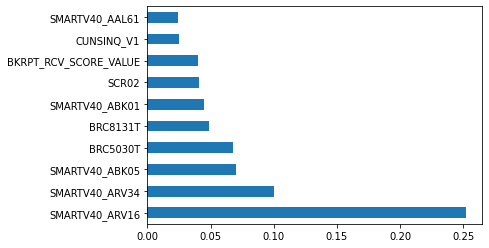

In [577]:
feat_importances = pd.Series(rf_3.feature_importances_, index=rf_best)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [0]:
shap_values = shap.TreeExplainer(rf_3, X[rf_best]).shap_values(X0[rf_best])
shap.summary_plot(shap_values, X0[rf_best])

# **Gradient Boosting Test**

In [0]:
gb_1 = GradientBoostingClassifier(loss= 'exponential',max_depth=3,min_samples_leaf=800, random_state=42, 
                                   n_estimators = 250, subsample = 0.9, criterion='friedman_mse',
                                   ccp_alpha=0.00,learning_rate=0.05, min_samples_split=18490,
                                   min_weight_fraction_leaf=0.01).fit(X0,Y0)

model_performance(X0, X1, Y0, Y1, gb_1)

In [0]:
param_gb = { "loss" : ['deviance', 'exponential'],
            "max_depth":range(5,10)
            }

gs_gb = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                   param_grid=param_gb, scoring="roc_auc", cv=3, n_jobs=-1)
gs_gb.fit(X0,Y0)

In [0]:
gs_gb.best_params_

In [0]:
gb_2 = GradientBoostingClassifier(loss= 'exponential',max_depth=3,min_samples_leaf=900, random_state=42, 
                                   n_estimators = 250).fit(X0,Y0)

model_performance(X0, X1, Y0, Y1, gb_2)

In [0]:
estimator = GradientBoostingClassifier(class_weight='balanced',max_depth=4,min_samples_leaf=10, random_state=42)
selector =  RFE(estimator, 6, step=1)
selector.fit(X0, Y0)
n_feature_rankings = 1
best_features_gb = X0.columns[selector.ranking_ <= n_feature_rankings]

gb_best_features_X0 = X0[best_features_gb]
gb_best_features_X1 = X1[best_features_gb]
gb_best_features_X = X[best_features_gb]

In [0]:
best_features_gb

In [0]:
gb_3 = GradientBoostingClassifier(loss= 'exponential',max_depth=3,min_samples_leaf=800, random_state=42, 
                                   n_estimators = 250, subsample = 0.9, criterion='friedman_mse',
                                   ccp_alpha=0.00,learning_rate=0.05, min_samples_split=18490,
                                   min_weight_fraction_leaf=0.01).fit(gb_best_features_X0,Y0)

model_performance(gb_best_features_X0, gb_best_features_X1, Y0, Y1, gb_3)

In [0]:
print("Mean 5-fold ROC AUC score for Tuned GB",np.mean(cross_val_score(estimator=gb_3,X=X,y=Y,cv=5, scoring="roc_auc")).round(2))

In [0]:
shap_values = shap.TreeExplainer(gb_1, data_1[best_features_dt]).shap_values(dt_best_features_X0)
shap.summary_plot(shap_values, dt_best_features_X0, plot_type="bar")
# Let's try using the features recommended by the DT model as replacements.

# **Final Model**

In [0]:
gb_final = GradientBoostingClassifier(loss= 'exponential',max_depth=3, random_state=42, 
                                      n_estimators = 40,learning_rate=0.04, 
                                      min_samples_leaf=900).fit(scaler.transform(X0_final),Y0_final)

model_performance(scaler.transform(X0_final),scaler.transform(X1_final),Y0_final, Y1_final, gb_final)

In [0]:
print("Mean 5-fold ROC AUC score for Tuned GB",np.mean(cross_val_score(estimator=gb_final,X=scaler.transform(X_final),
                                                                       y=Y_final,cv=5, scoring="roc_auc")).round(3))

# **Model Interpretation**

In [0]:
shap_values = shap.TreeExplainer(gb_final, data_2).shap_values(X0_final)
# shap.dependence_plot("EXP_ID", shap_values, X0_final)
shap.force_plot()

In [0]:
estimator = DecisionTreeClassifier(class_weight='balanced',max_depth=3,min_samples_leaf=104, random_state=42)
selector =  RFE(estimator, 4, step=1)
selector.fit(X0_final, Y0_final)
n_feature_rankings = 1
best_features_dt = X0_final.columns[selector.ranking_ <= n_feature_rankings]

dt_best_features_X0 = X0_final[best_features_dt]
dt_best_features_X1 = X1_final[best_features_dt]
dt_best_features_X = X_final[best_features_dt]


dt_2 = DecisionTreeClassifier(class_weight='balanced',max_depth=3,min_samples_leaf=104, random_state=42).fit(dt_best_features_X0,Y0_final)
model_performance(dt_best_features_X0, dt_best_features_X1, Y0_final, Y1_final, dt_2)
plt.figure(figsize=(10, 10))
plot_tree(dt_2,feature_names= dt_best_features_X.columns, filled=True)
# plt.savefig('my.png')
plt.show()

In [0]:
print('Counts: ', data.groupby('RESPONSE_FLAG')['EXP_ID'].count(), '\n')
print('Means: ', data.groupby('RESPONSE_FLAG')['EXP_ID'].mean())

In [0]:
data_2.EXP_ID.value_counts()

In [0]:
sns.pairplot(data_2[['CUNSINQ_V1', 'EXP_ID', 'SCR02', 'SMARTV40_ARV16', 
                     'SMARTV40_ASL01','SMARTV40_ASL09', 'RESPONSE_FLAG']])
plt.show()

In [0]:
print(logit_model_1.summary())

In [0]:
print(logit_model_1.get_margeff().summary())

# **ROC Curve**

In [0]:
FPR, TPR, thresholds = roc_curve(Y1_final, gb_final.predict_proba(scaler.transform(X1_final))[:,1])
#plotting ROC AUC for Logistic Regression
plt.plot(FPR, TPR, label=f"ROC AUC{roc_auc_score(Y1_final,gb_final.predict_proba(scaler.transform(X1_final))[:,1]).round(2)}")
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

# **Gain Curve**

In [0]:
skplt.metrics.plot_cumulative_gain(Y1_final,gb_final.predict_proba(scaler.transform(X1_final)))
plt.show()

# **Lift Curve**

In [0]:
skplt.metrics.plot_lift_curve(Y1_final,gb_final.predict_proba(scaler.transform(X1_final)))
plt.show()